In [182]:
from pyspark import SparkContext, SparkConf
from timeit import default_timer
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
#%matplotlib notebook

In [203]:
# Pendant les test pour stopper un SparkContext
#sc.stop()

In [183]:
# Connexion au cluster / test en local
spark_conf = SparkConf()\
    .setAppName('Page Rank With PySpark')\
    .setMaster('local')
sc = SparkContext(conf=spark_conf)

# Premiers tests sur quelques pages 

Tests éffectués à partir d'un fichier listant les noeuds représentant les pages web et leurs liens.
Fichier Web graphs extrait du site : http://snap.stanford.edu/data/index.html

In [184]:
# Taille du fichier initial = dfFile.shape = (5105039, 2)
#dfFile = pd.read_csv("web-Google.txt", sep='\t', header=3)

In [185]:
# Préparation du fichier avant utilisation dans l'algo
# Pour les tests récupérations des x premières lignes uniquement 
dfFile = pd.read_csv("data/web-Google.txt", sep='\t', header=3, nrows = 60)
print(dfFile.shape)
#Etant donné que nous ne sélectionons qu'une partie du fichier les noeuds sont filtrés en conséquence
nodesList = dfFile['# FromNodeId'].unique()
dfFileUniqueNodes = dfFile[dfFile['ToNodeId'].isin(nodesList)]
dfFileUniqueNodes.to_csv("data/web-GoogleSmall.txt", sep=' ', header=False, index=False)
print(dfFileUniqueNodes.shape)

(60, 2)
(16, 2)


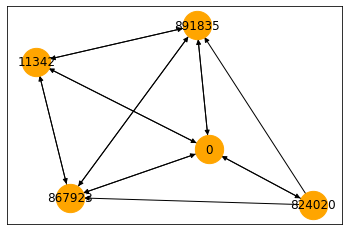

In [189]:
# Représentation graphique des noeuds (pages) et des liens entre ces noeuds (pages)
graph_nodes=nx.from_pandas_edgelist(dfFileUniqueNodes, '# FromNodeId', 'ToNodeId',create_using=nx.DiGraph())
graph_nodes=nx.draw_networkx(graph_nodes, node_color = 'orange', node_size = 800,arrows=True)
plt.savefig('graph/graph_nodes_test.png')

In [190]:
# Read the text file "GoogleSmall.txt" from a local file system (available on all nodes),
# and return it as an RDD of Strings.
RddDataBase = sc.textFile("data/web-GoogleSmall.txt")

In [191]:
def linkNodesFromTo(NodesRow):
    nodeslinked = NodesRow.split(' ') 
    return nodeslinked[0], nodeslinked[1]

# Premier test en mettant en cache

Using cache() and persist() methods, Spark provides an optimization mechanism to store the intermediate computation of an RDD so they can be reused in subsequent actions.When you persist or cache an RDD, each worker node stores it’s partitioned data in memory or disk and reuses them in other actions on that RDD. And Spark’s persisted data on nodes are fault-tolerant meaning if any partition is lost, it will automatically be recomputed using the original transformations that created it.
Spark RDD cache() method by default saves RDD computation to storage level `MEMORY_ONLY` meaning it will store the data in the JVM heap as unserialized objects.

In [199]:
# First step :
# Create key/value pairs, 
# where the key is the name of the page and the value is out-links from the page (Di) 
# and İnitiate PageRank values (Ri) as 1/Number of pages.

# Mapping / Shuffling
# Key/value pairs
links = RddDataBase.map(lambda NodesRow: linkNodesFromTo(NodesRow)).distinct().groupByKey().cache()
print(links.collect())
#print(RddDataBase.map(lambda NodesRow: linkNodesFromTo(NodesRow)).distinct().\
#                        groupByKey().\
#                        map(lambda x : (x[0], list(x[1])))\
#      .collect())

# Find node count
N = links.count()
print(N)

# Create and initialize the ranks
ranks = links.map(lambda node: (node[0],1.0/N))
print(ranks.collect())

print('Seconde étape : ')
#Map: For each node i, 
#calculate vote (Ri/Di) for each out-link of i and propagate to adjacent nodes.
#Reduce: For each node i, sum the upcoming votes and update Rank value (Ri).
#Repeat this Map-Reduce step until Rank values converge (stable or within a margin).
start = default_timer()
nbIter=20
for i in range(nbIter):
    # Join graph info with rank info and propogate to all neighbors rank scores (rank/(number of neighbors)
    # And add up ranks from all in-coming edges
    ranks = links.join(ranks).flatMap(lambda x : [(i, float(x[1][1])/len(x[1][0])) for i in x[1][0]])\
                    .reduceByKey(lambda x,y: x+y)
    print(ranks.sortByKey().collect())

#Vérifie le temps de calcul
duration = default_timer() - start
print(f'Le temps de calcul en secondes est de : {duration}, en minutes est de : {duration/60}')

[('0', <pyspark.resultiterable.ResultIterable object at 0x0000020B70C211F0>), ('11342', <pyspark.resultiterable.ResultIterable object at 0x0000020B70829430>), ('824020', <pyspark.resultiterable.ResultIterable object at 0x0000020B70C3B250>), ('867923', <pyspark.resultiterable.ResultIterable object at 0x0000020B70C3B520>), ('891835', <pyspark.resultiterable.ResultIterable object at 0x0000020B70C3B100>)]
5
[('0', 0.2), ('11342', 0.2), ('824020', 0.2), ('867923', 0.2), ('891835', 0.2)]
Seconde étape : 
[('0', 0.26666666666666666), ('11342', 0.18333333333333335), ('824020', 0.05), ('867923', 0.25), ('891835', 0.25)]
[('0', 0.2444444444444444), ('11342', 0.23333333333333334), ('824020', 0.06666666666666667), ('867923', 0.22777777777777775), ('891835', 0.22777777777777775)]
[('0', 0.2518518518518518), ('11342', 0.2129629629629629), ('824020', 0.0611111111111111), ('867923', 0.23703703703703702), ('891835', 0.23703703703703702)]
[('0', 0.24938271604938267), ('11342', 0.22098765432098766), ('82

# Second test sans mettre en cache

In [200]:
links = RddDataBase.map(lambda NodesRow: linkNodesFromTo(NodesRow)).distinct().\
                        groupByKey().\
                        map(lambda x : (x[0], list(x[1])))
print(links.collect())
N = links.count()
print(N)
ranks = links.map(lambda node: (node[0],1.0/N))
print(ranks.collect())

start = default_timer()
nbIter=20
for i in range(nbIter):
    ranks = links.join(ranks).flatMap(lambda x : [(i, float(x[1][1])/len(x[1][0])) for i in x[1][0]])\
                    .reduceByKey(lambda x,y: x+y)
    print(ranks.sortByKey().collect())

#Vérifie le temps de calcul
duration = default_timer() - start
print(f'Le temps de calcul en secondes est de : {duration}, en minutes est de : {duration/60}')

[('0', ['11342', '824020', '867923', '891835']), ('11342', ['0', '867923', '891835']), ('824020', ['0', '867923', '891835']), ('867923', ['0', '11342', '891835']), ('891835', ['0', '11342', '867923'])]
5
[('0', 0.2), ('11342', 0.2), ('824020', 0.2), ('867923', 0.2), ('891835', 0.2)]
[('0', 0.26666666666666666), ('11342', 0.18333333333333335), ('824020', 0.05), ('867923', 0.25), ('891835', 0.25)]
[('0', 0.2444444444444444), ('11342', 0.23333333333333334), ('824020', 0.06666666666666667), ('867923', 0.22777777777777775), ('891835', 0.22777777777777775)]
[('0', 0.2518518518518518), ('11342', 0.2129629629629629), ('824020', 0.0611111111111111), ('867923', 0.23703703703703702), ('891835', 0.23703703703703702)]
[('0', 0.24938271604938267), ('11342', 0.22098765432098766), ('824020', 0.06296296296296296), ('867923', 0.23333333333333328), ('891835', 0.2333333333333333)]
[('0', 0.2502057613168724), ('11342', 0.21790123456790123), ('824020', 0.06234567901234567), ('867923', 0.23477366255144033), 

@Kim le test n'est pas concluant car même temps si on met cache() ou pas :(

# Test sur l'ensemble des données

In [202]:
# Préparation du fichier avant utilisation dans l'algo
dfFileAll = pd.read_csv("data/web-Google.txt", sep='\t', header=3)
print(dfFileAll.shape)
nodesList = dfFileAll['# FromNodeId'].unique()
dfFileAllUniqueNodes = dfFileAll[dfFileAll['ToNodeId'].isin(nodesList)]
dfFileAllUniqueNodes.to_csv("data/web-GoogleAll.txt", sep=' ', header=False, index=False)
print(dfFileAllUniqueNodes.shape)

RddDataBase = sc.textFile("data/web-GoogleAll.txt")
links = RddDataBase.map(lambda NodesRow: linkNodesFromTo(NodesRow)).distinct().groupByKey().cache()
print(links.collect())

N = links.count()
print(N)

ranks = links.map(lambda node: (node[0],1.0/N))
print(ranks.collect())

print('Seconde étape : ')

start = default_timer()
nbIter=5
for i in range(nbIter):
    ranks = links.join(ranks).flatMap(lambda x : [(i, float(x[1][1])/len(x[1][0])) for i in x[1][0]])\
                    .reduceByKey(lambda x,y: x+y)
    print(ranks.sortByKey().collect())

#Vérifie le temps de calcul
duration = default_timer() - start
print(f'Le temps de calcul en secondes est de : {duration}, en minutes est de : {duration/60}')

(5105039, 2)
(4779314, 2)


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



703607


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



KeyboardInterrupt: 